# Time series prediction with Deep Learning. LSTM model. EarlyStopping

The following notebook details the process of training a neural network with LSTM models. Code based on https://github.com/gianfelton and course https://www.coursera.org/projects/series-temporales-con-deep-learning-rnn-lstm-prophet

**Virtual environment with the following configuration:**
python==3.10.12   h5py==3.9.0    numpy==1.25.2   tensorflow==2.15.0   pandas==2.0.3   statsmodel==0.14.1   matplotlib==3.7.1
sklearn==1.2.2    keras==2.15.0  prophet==1.1.5  seaborn==0.12.2      cmdstanpy==1.2.2

#### Set the TensorFlow logging level to ERROR, which means only error messages will be displayed and warnings will be ignored.

In [ ]:
import os
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#### Import libraries

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt                    
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

#### Data Import

In [3]:
df = pd.read_csv('monthly-beer-production-in-austr.csv')

#### Data exploration

In [4]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


## Data Pre-processing

#### Format change on data

In [6]:
df.Month = pd.to_datetime(df.Month)

#### index creation

In [7]:
df = df.set_index("Month")
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


#### Definition of index frequency = Monthly

In [8]:
df.index.freq = 'MS'

#### data graph

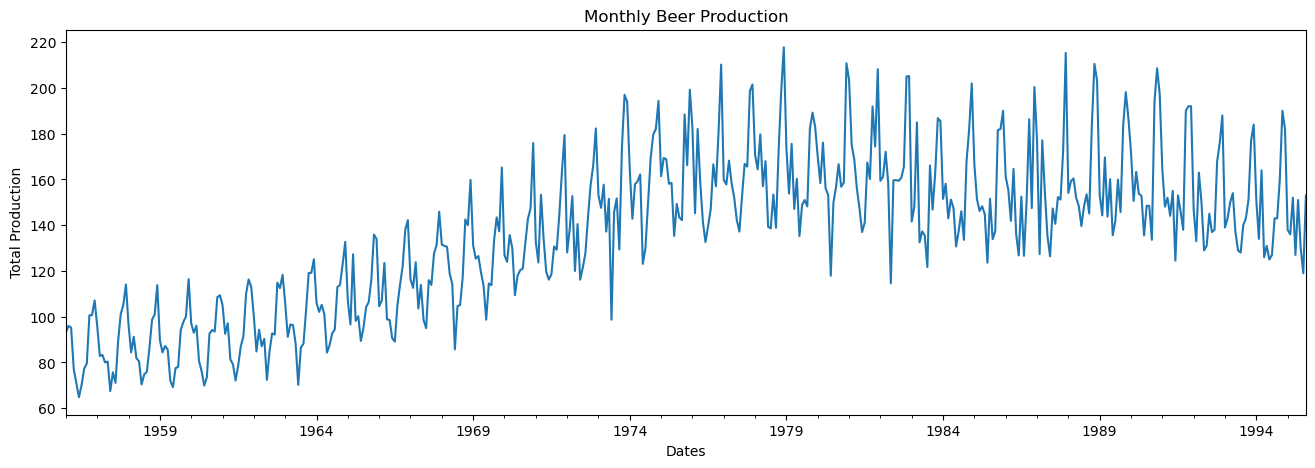

In [9]:
ax = df['Monthly beer production'].plot(figsize = (16,5), title = "Monthly Beer Production")
ax.set(xlabel='Dates', ylabel='Total Production');

##### seasonal_decompose

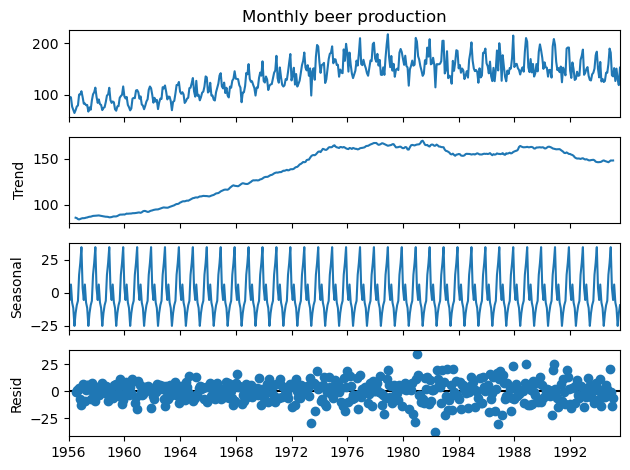

In [10]:
a = seasonal_decompose(df["Monthly beer production"], model = "add")
a.plot();

#### seasonal_plot

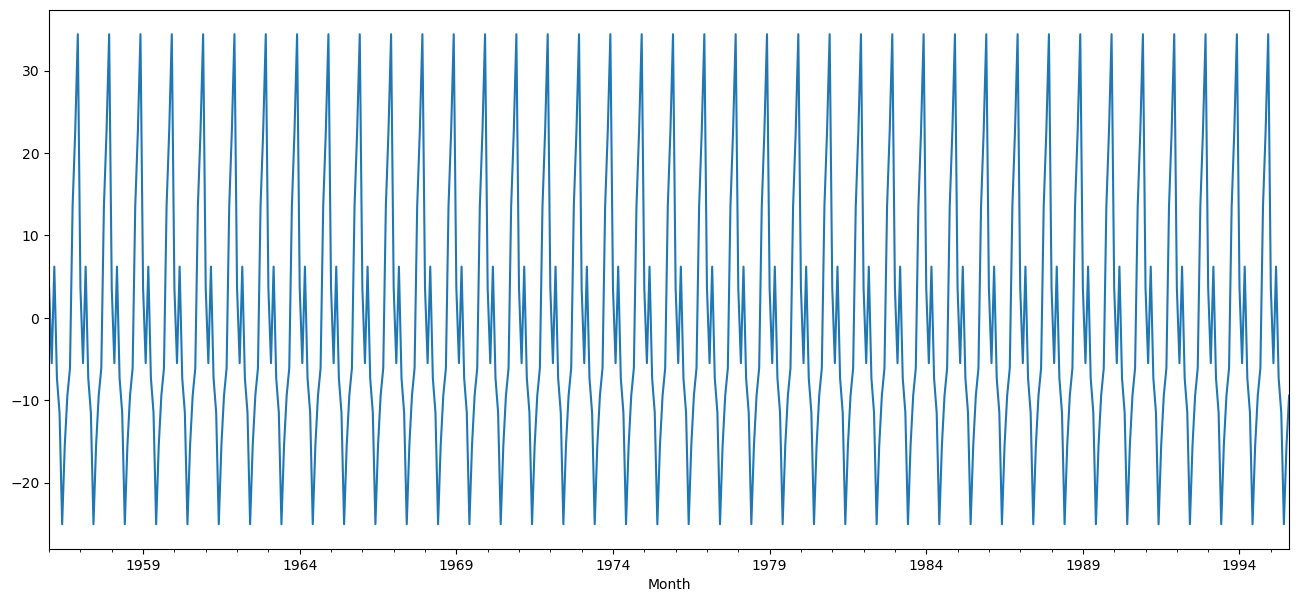

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

#### training and testing data set definition

In [12]:
#The training data set ends 48 periods earlier than the original data set
train_data = df[:len(df)-48]

#The test data set starts when there are 12 periods left before the end of the original data set
test_data = df[len(df)-48:]

#### Data preprocessing with MinMaxScaler

In [13]:
#import library
from sklearn.preprocessing import MinMaxScaler

#definition of the normalization method
scaler = MinMaxScaler()

In [14]:
#scaler learns the parameters from the training data. These parameters are used to transform the data.
scaler.fit(train_data)

#the training data is scaled (e.g., standardized or normalized) using the parameters learned in the previous step.
scaled_train_data = scaler.transform(train_data)

#the test data is scaled (e.g., standardized or normalized) using the parameters learned in the previous step.
scaled_test_data = scaler.transform(test_data)

#### Creation of the Time Series Generator object.

**from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator**. Here, the TimeseriesGenerator class of the 
tensorflow.keras.preprocessing.sequence module. **TimeseriesGenerator** is a TensorFlow utility for generating 
batches of time series data, where the input and output data are sampled uniformly over time.

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Let's redefine to get 12 months back and then predict the next month out
#input is the number of time steps that will be used as input to predict the next time step (12 prediction periods)
n_input = 12

#n_features is the number of features in the input data. In this case, there is only one feature.
n_features= 1

#create the TimeseriesGenerator instance
#The arguments are the input and output data (in this case, both are scaled_train_data)
#TimeseriesGenerator will generate batches of 12 consecutive time slots of scaled_train_data as input and the 
#13th time slot as output.
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, 
                                length=n_input, batch_size=1)

#### Transformation example

In [16]:
X,y = generator[0]

In [17]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.18562092 0.20392157 0.19869281 0.08039216 0.03986928 0.
 0.03464052 0.08169935 0.09607843 0.23398693 0.23464052 0.27647059]
Predict this y: 
 [[0.20326797]]


## LSTM model training with EarlyStopping

### Advanced LSTM Model (EarlyStopping)

A checkpoint (**ModelCheckpoint**) is created to save the best trained model based on validation loss (**val_loss**).

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout

In [19]:
#creation of the sequential model.
lstm_model = Sequential()

#adding an LSTM (Long Short-Term Memory) layer. With 200 neurons, ReLU (Rectified Linear Unit) activation function, 
#n_input = 12 prediction periods, n_features = only one feature
lstm_model.add(LSTM(200, activation='relu',return_sequences=True,
                    input_shape=(n_input, n_features)))

#adding an LSTM layer with 200 neuron and return_sequences=True (returns output sequences to add another layer)
lstm_model.add(LSTM(200, return_sequences=True))

#Dropout layer randomly removes some neurons to avoid overfitting
lstm_model.add(Dropout(rate=0.2))

##adding an LSTM layer with 200 neuron and return_sequences=false (does not return output sequences and no more layers are added)
lstm_model.add(LSTM(200, return_sequences=False))

#adding a dense layer to your model (results output)
lstm_model.add(Dense(1))

#ModelCheckpoint, allows you to save the best model of the training process in .h5 format, "val_:loss" metric, 
#save_best_only=True (saves the best model according to "val_:loss")
mc = ModelCheckpoint('best_modelo_lstm.h5', monitor='val_loss', mode='min', 
                     verbose=1, save_best_only=True)
#model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 200)           161600    
                                                                 
 lstm_1 (LSTM)               (None, 12, 200)           320800    
                                                                 
 dropout (Dropout)           (None, 12, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 803401 (3.06 MB)
Trainable params: 803401 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
#model compilation. Optimizer = adam, loss='mse' (Mean Squared Error)
lstm_model.compile(optimizer='adam', loss='mse')

In [21]:
#model fit
lstm_model.fit(generator,epochs=20)

Epoch 1/20
416/416 [==============================] - 73s 110ms/step - loss: 0.0269
Epoch 2/20
416/416 [==============================] - 46s 109ms/step - loss: 0.0152
Epoch 3/20
416/416 [==============================] - 51s 123ms/step - loss: 0.0148
Epoch 4/20
416/416 [==============================] - 46s 111ms/step - loss: 0.0111
Epoch 5/20
416/416 [==============================] - 46s 110ms/step - loss: 0.0087
Epoch 6/20
416/416 [==============================] - 46s 111ms/step - loss: 0.0078
Epoch 7/20
416/416 [==============================] - 47s 113ms/step - loss: 0.0083
Epoch 8/20
416/416 [==============================] - 46s 110ms/step - loss: 0.0084
Epoch 9/20
416/416 [==============================] - 46s 111ms/step - loss: 0.0083
Epoch 10/20
416/416 [==============================] - 49s 119ms/step - loss: 0.0075
Epoch 11/20
416/416 [==============================] - 50s 119ms/step - loss: 0.0074
Epoch 12/20
416/416 [==============================] - 48s 115ms/step - lo

### EarlyStopping and Validation Generator 

In [22]:
#import library
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
# An early_stop object is created using the Keras EarlyStopping class
#The monitor argument specifies which metric should be monitored (in this case, validation loss).
#The patience argument indicates how many epochs to wait without improvements in the metric before stopping training (12 epochs).
early_stop = EarlyStopping(monitor='val_loss',
                           patience=12)

In [24]:
#Time series generator for validation
#A time series generator called validation_generator is created.
#This generator is used to generate test data sequences with length equal to n_input (12 predictions).
validation_generator = TimeseriesGenerator(scaled_test_data,scaled_test_data, 
                                           length=n_input)

In [25]:
#model compilation. Optimizer = adam, loss='mse' (Mean Squared Error)
lstm_model.compile(optimizer='adam', 
              loss='mse')

In [26]:
# fit model with EarlyStopping (early_stop), Validation Generator (validation_generator) and ModelCheckpoint (mc)
lstm_model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop, mc])

Epoch 1/20
416/416 [==============================] - ETA: 0s - loss: 0.0067
Epoch 1: val_loss improved from inf to 0.00562, saving model to best_modelo_lstm.h5
416/416 [==============================] - 80s 134ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 2/20
416/416 [==============================] - ETA: 0s - loss: 0.0069
Epoch 2: val_loss did not improve from 0.00562
416/416 [==============================] - 52s 124ms/step - loss: 0.0069 - val_loss: 0.0149
Epoch 3/20
416/416 [==============================] - ETA: 0s - loss: 0.0066
Epoch 3: val_loss did not improve from 0.00562
416/416 [==============================] - 46s 110ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 4/20
416/416 [==============================] - ETA: 0s - loss: 0.0067
Epoch 4: val_loss improved from 0.00562 to 0.00470, saving model to best_modelo_lstm.h5
416/416 [==============================] - 46s 111ms/step - loss: 0.0067 - val_loss: 0.0047
Epoch 5/20
416/416 [==============================] - ETA:

#### Learning curve

Training and validation learning curve

<Axes: >

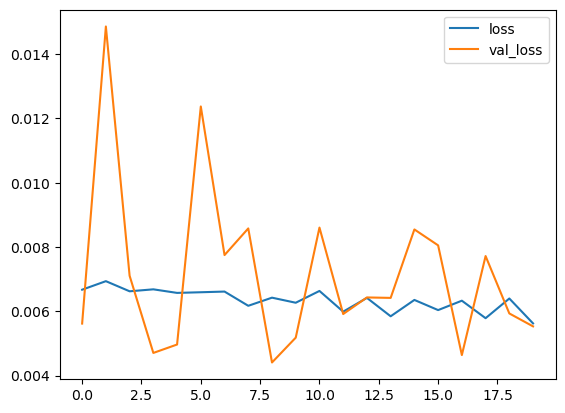

In [27]:
losses = pd.DataFrame(lstm_model.history.history)
losses.plot()

## Prediction on test data

#### load the model

In [28]:
from keras.models import load_model

lstm_model = load_model('best_modelo_lstm.h5', compile=False)

Next we are going to make a prediction for 12 months (12 predictions). To do this we are going to do the following:
- create an empty list for each of our 12 predictions
- create the batch that our model will predict
- save the prediction to our list
- add the prediction to the end of the batch to use it in the next prediction

In [29]:
# create an empty list for each of our 12 predictions
lstm_predictions_scaled = list()

#create the batch that our model will predict: 
#selecting the last n_input data points from the scaled training data set to form the first batch of data to be 
#fed to the LSTM model.
batch = scaled_train_data[-n_input:]

#adjusting the batch of data to have the shape required by the LSTM model, which is (number of samples, time steps,
#number of features).
current_batch = batch.reshape((1, n_input, n_features))

#save the prediction to our list:
#The for loop is iterating over each data point in the test data set. For each iteration, do the following:

for i in range(len(test_data)):   
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    lstm_pred = lstm_model.predict(current_batch)[0]
    
    # store prediction
    lstm_predictions_scaled.append(lstm_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 121ms/step


As you know, we scale our data, so we have to invert it to see original predictions.

In [30]:
#LSTM model predictions
lstm_predictions_scaled

[array([0.57315904], dtype=float32),
 array([0.76633316], dtype=float32),
 array([0.81383854], dtype=float32),
 array([0.7518901], dtype=float32),
 array([0.5977545], dtype=float32),
 array([0.538842], dtype=float32),
 array([0.5375757], dtype=float32),
 array([0.5115299], dtype=float32),
 array([0.5151246], dtype=float32),
 array([0.4531995], dtype=float32),
 array([0.5212218], dtype=float32),
 array([0.5144986], dtype=float32),
 array([0.569285], dtype=float32),
 array([0.6967876], dtype=float32),
 array([0.72615075], dtype=float32),
 array([0.6656985], dtype=float32),
 array([0.56441003], dtype=float32),
 array([0.52993786], dtype=float32),
 array([0.51963454], dtype=float32),
 array([0.49848795], dtype=float32),
 array([0.48730654], dtype=float32),
 array([0.46435577], dtype=float32),
 array([0.49442244], dtype=float32),
 array([0.5046501], dtype=float32),
 array([0.5524704], dtype=float32),
 array([0.63400507], dtype=float32),
 array([0.6515089], dtype=float32),
 array([0.6012091]

### Reverse the transformation

In [31]:
#downscaling the LSTM model predictions so that they are on the same scale as the original data
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [32]:
lstm_predictions

array([[152.49333297],
       [182.04897391],
       [189.31729685],
       [179.8391888 ],
       [156.2564352 ],
       [147.24282943],
       [147.04908543],
       [143.06407814],
       [143.61406671],
       [134.13952439],
       [144.54693793],
       [143.51828449],
       [151.90060126],
       [171.40850215],
       [175.90106492],
       [166.65187483],
       [151.15473472],
       [145.88049309],
       [144.30408536],
       [141.06865625],
       [139.35789989],
       [135.84643232],
       [140.44663267],
       [142.01146774],
       [149.32796906],
       [161.80277567],
       [164.48086588],
       [156.78499292],
       [147.85101871],
       [144.54269736],
       [142.52869903],
       [139.69408153],
       [137.68314736],
       [136.1788476 ],
       [138.50080268],
       [140.76984637],
       [146.56061708],
       [153.62428908],
       [155.09162747],
       [150.24850159],
       [145.50232522],
       [143.28284608],
       [141.25548767],
       [138

In [33]:
#adding the LSTM model predictions to the test data set.
test_data['LSTM_Predictions'] = lstm_predictions

In [34]:
test_data

,Monthly beer production,LSTM_Predictions
Month,,
1991-09-01,138.0,152.493333
1991-10-01,190.0,182.048974
1991-11-01,192.0,189.317297
1991-12-01,192.0,179.839189
1992-01-01,147.0,156.256435
1992-02-01,133.0,147.242829
1992-03-01,163.0,147.049085
1992-04-01,150.0,143.064078
1992-05-01,129.0,143.614067


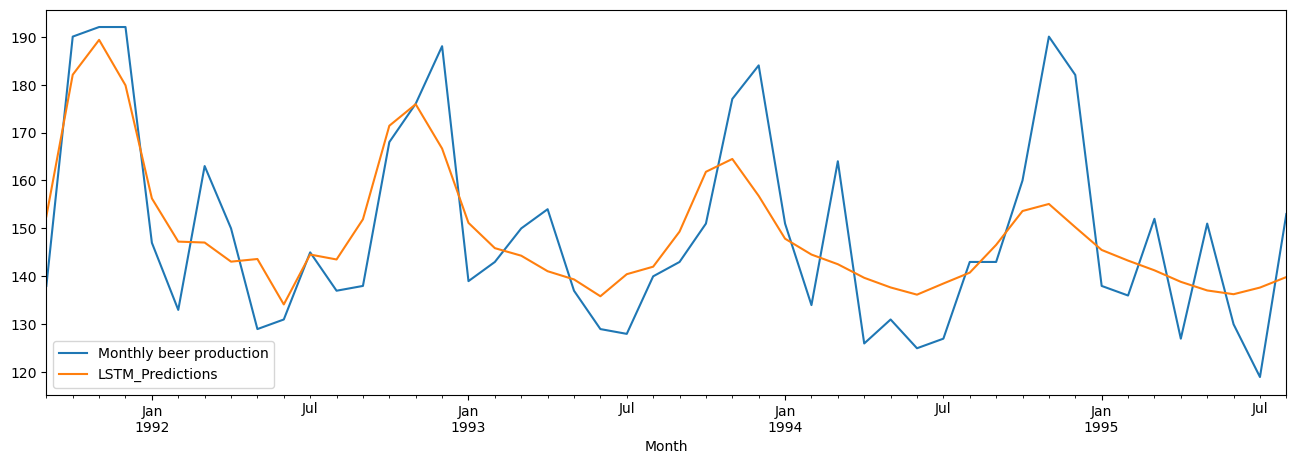

In [35]:
#actual monthly beer production and LSTM model predictions on the same graph.
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [36]:
#calculating the root mean square error (RMSE) between the actual monthly beer production and the LSTM model predictions.
lstm_rmse_error = rmse(test_data['Monthly beer production'], test_data["LSTM_Predictions"])

#calculating the mean square error (MSE) by squaring the RMSE.
lstm_mse_error = lstm_rmse_error**2

#calculating the average value of monthly beer production.
mean_value = df['Monthly beer production'].mean()

#the MSE, and RMSE and the mean value are printed.
print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 167.5840435326662
RMSE Error: 12.945425583296448
Mean: 136.3953781512605


### Retrain and predict new data

#### Data preprocessing with MinMaxScaler

In [37]:
#definition of the normalization method
full_scaler = MinMaxScaler()

#scaler learns the parameters from the data frame. These parameters are used to transform the data.
#the data frame is scaled (e.g., standardized or normalized) using the parameters learned.
scaled_full_data = full_scaler.fit_transform(df)

#### Creation of the Time Series Generator object.

In [38]:
#input is the number of time steps that will be used as input to predict the next time step (12 prediction periods)
length = 12 # Length of the output sequences (in number of timesteps)

#create the TimeseriesGenerator instance
#The arguments are the input and output data (in this case, both are scaled_train_data)
#TimeseriesGenerator will generate batches of 12 consecutive time slots of scaled_train_data as input and the 
#13th time slot as output.
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

#### Retrain basic LSTM model

In [39]:
#creation of the sequential model.
model = Sequential()

#adding an LSTM (Long Short-Term Memory) layer. With 100 neurons, ReLU (Rectified Linear Unit) activation function, 
#n_input = 12 prediction periods, n_features = only one feature
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

#adding a dense layer to your model (results output)
model.add(Dense(1))

#model compilation. Optimizer = adam, loss='mse' (Mean Squared Error)
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
464/464 [==============================] - 19s 27ms/step - loss: 0.0198
Epoch 2/8
464/464 [==============================] - 13s 27ms/step - loss: 0.0130
Epoch 3/8
464/464 [==============================] - 13s 27ms/step - loss: 0.0110
Epoch 4/8
464/464 [==============================] - 13s 27ms/step - loss: 0.0096
Epoch 5/8
464/464 [==============================] - 13s 27ms/step - loss: 0.0089
Epoch 6/8
464/464 [==============================] - 13s 27ms/step - loss: 0.0080
Epoch 7/8
464/464 [==============================] - 13s 27ms/step - loss: 0.0077
Epoch 8/8
464/464 [==============================] - 13s 27ms/step - loss: 0.0072


#### extra sample forecasts (new data)

In [40]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

#create the batch that our model will predict: 
first_eval_batch = scaled_full_data[-length:]

#adjusting the batch of data to have the shape required by the LSTM model, which is (number of samples, time steps,
#number of features).
current_batch = first_eval_batch.reshape((1, length, n_features))

#save the prediction to our list:
#The for loop is iterating over each data point in the test data set. For each iteration, do the following:
for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 103ms/step


In [41]:
#LSTM model predictions
forecast

[array([0.56949365], dtype=float32),
 array([0.6843338], dtype=float32),
 array([0.7828459], dtype=float32),
 array([0.7341364], dtype=float32),
 array([0.55272263], dtype=float32),
 array([0.5421852], dtype=float32),
 array([0.54987687], dtype=float32),
 array([0.49310073], dtype=float32),
 array([0.5284743], dtype=float32),
 array([0.44218743], dtype=float32),
 array([0.46060735], dtype=float32),
 array([0.5535676], dtype=float32)]

In [42]:
#downscaling the LSTM model predictions so that they are on the same scale as the original data
forecast = scaler.inverse_transform(forecast)

In [43]:
forecast

array([[151.93252866],
       [169.50307159],
       [184.5754249 ],
       [177.1228696 ],
       [149.36656283],
       [147.75433366],
       [148.93116091],
       [140.24441208],
       [145.65656351],
       [132.45467656],
       [135.27292453],
       [149.49584101]])

In [44]:
#LSTM model predictions on the test data set.
test_data.tail()

,Monthly beer production,LSTM_Predictions
Month,,
1995-04-01,127.0,138.853956
1995-05-01,151.0,137.056300
1995-06-01,130.0,136.271566
1995-07-01,119.0,137.658315
1995-08-01,153.0,139.850244


In [45]:
#create forecast index for 12 extra-sample periods (starts from 1995-08-01 - periods)
forecast_index = pd.date_range(start='1995-08-01',periods=periods,freq='MS')

In [46]:
# Generate forecast data frame
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])
forecast_df

,Forecast
1995-08-01,151.932529
1995-09-01,169.503072
1995-10-01,184.575425
1995-11-01,177.122870
1995-12-01,149.366563
1996-01-01,147.754334
1996-02-01,148.931161
1996-03-01,140.244412
1996-04-01,145.656564
1996-05-01,132.454677


<Axes: >

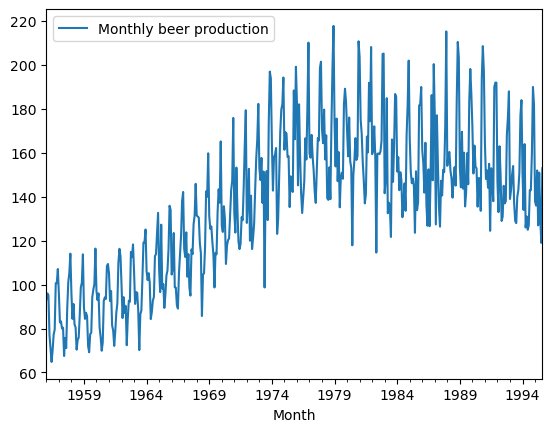

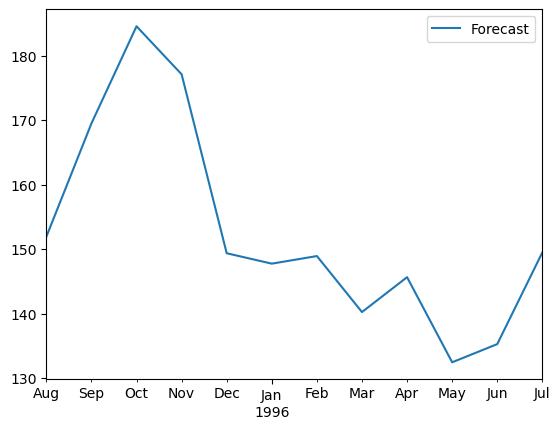

In [47]:
#data frame and forecasts graph 
df.plot()
forecast_df.plot()

<Axes: xlabel='Month'>

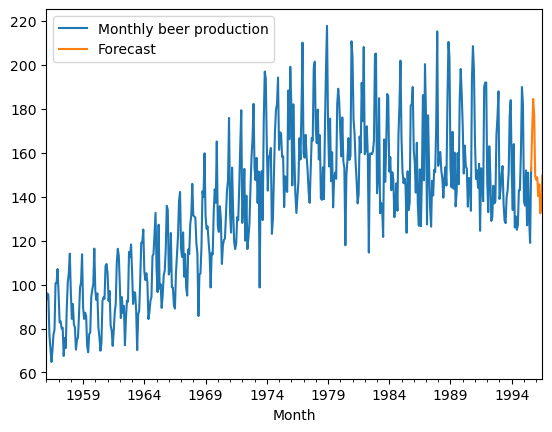

In [48]:
#graph of the data frame and forecasts in a single graph
ax = df.plot()
forecast_df.plot(ax=ax)

(283.0, 318.0)

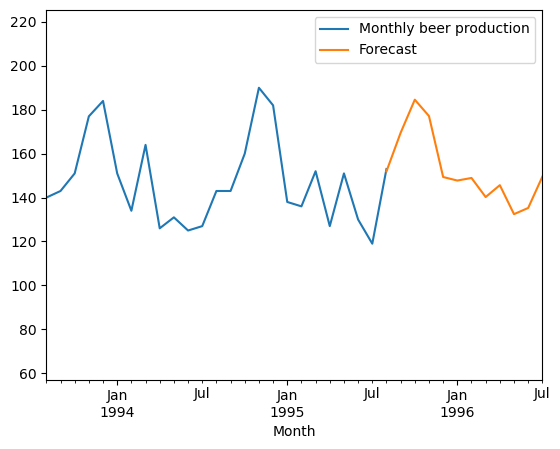

In [49]:
#graph of the data frame and forecasts in a single graph with zoom
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('1993-08-01','1996-07-01')

#### Retrain Advance LSTM model

In [50]:
forecast_best = []
# Replace periods with whatever forecast length you want
periods = 12

#create the batch that our model will predict: 
first_eval_batch = scaled_full_data[-length:]

#adjusting the batch of data to have the shape required by the LSTM model, which is (number of samples, time steps,
#number of features).
current_batch = first_eval_batch.reshape((1, length, n_features))

#save the prediction to our list:
#The for loop is iterating over each data point in the test data set. For each iteration, do the following:
for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = lstm_model.predict(current_batch)[0]
    
    # store prediction
    forecast_best.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 117ms/step


In [51]:
#Best LSTM model predictions
forecast_best

[array([0.52357924], dtype=float32),
 array([0.6139733], dtype=float32),
 array([0.73176396], dtype=float32),
 array([0.6634304], dtype=float32),
 array([0.4897812], dtype=float32),
 array([0.49845898], dtype=float32),
 array([0.52386755], dtype=float32),
 array([0.45680332], dtype=float32),
 array([0.5060205], dtype=float32),
 array([0.4350257], dtype=float32),
 array([0.43641055], dtype=float32),
 array([0.52621055], dtype=float32)]

In [52]:
#downscaling the LSTM model predictions so that they are on the same scale as the original data
forecast_best = scaler.inverse_transform(forecast_best)

In [53]:
forecast_best 

array([[144.9076237 ],
       [158.73791789],
       [176.75988572],
       [166.30485009],
       [139.73652374],
       [141.06422417],
       [144.95173477],
       [134.69090824],
       [142.22113441],
       [131.35893087],
       [131.57081358],
       [145.31021361]])

In [54]:
# Generate forecast data frame
forecast_df_best = pd.DataFrame(data=forecast_best,index=forecast_index,
                           columns=['Forecast_best'])
forecast_df_best

,Forecast_best
1995-08-01,144.907624
1995-09-01,158.737918
1995-10-01,176.759886
1995-11-01,166.304850
1995-12-01,139.736524
1996-01-01,141.064224
1996-02-01,144.951735
1996-03-01,134.690908
1996-04-01,142.221134
1996-05-01,131.358931


(283.0, 318.0)

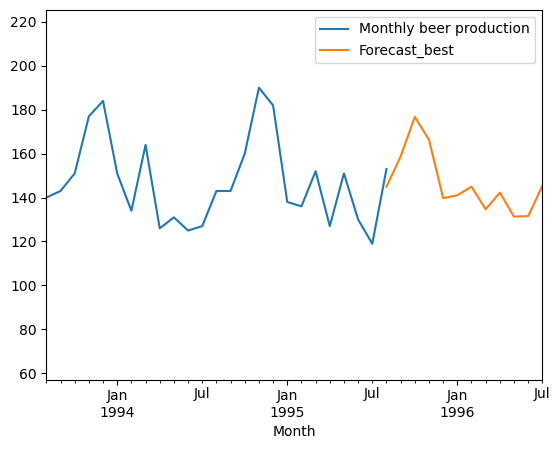

In [55]:
#graph of the data frame and forecasts in a single graph with zoom
ax = df.plot()
forecast_df_best.plot(ax=ax)
plt.xlim('1993-08-01','1996-07-01')

(283.0, 318.0)

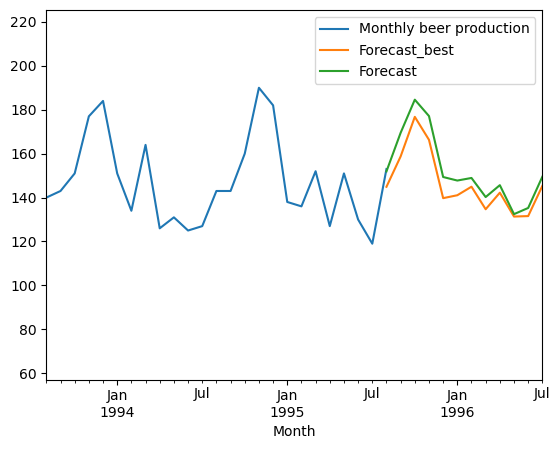

In [56]:
#graph of the data frame and forecasts in a single graph with zoom
ax = df.plot()
forecast_df_best.plot(ax=ax)
forecast_df.plot(ax=ax)
plt.xlim('1993-08-01','1996-07-01')

## Prediction with Prophet

#### data exploration

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Freq: MS
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Monthly beer production  476 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB


#### duplicate data

In [58]:
# create a separate copy of the data
df_pr = df.copy()

#reset the DataFrame index and replace it with a new default numeric index.
df_pr = df.reset_index()

In [59]:
#rename the columns of your DataFrame so you can use it with Prophet. The ds column must contain the dates and the y column 
#must contain the numerical values that you want to predict
df_pr.columns = ['ds','y'] # To use prophet column names should be like that

In [60]:
#The training data set ends 48 periods earlier than the original data set
train_data_pr = df_pr.iloc[:len(df)-48]

#The test data set starts when there are 12 periods left before the end of the original data set
test_data_pr = df_pr.iloc[len(df)-48:]

In [67]:
#import library
import os
os.environ['CMDSTAN'] = "C:/Users/UserA/anaconda3/envs/myenvA/Library/bin/cmdstan"
import prophet
from prophet import Prophet

In [69]:
#start a new Prophet model object
m = Prophet()

#model fit
m.fit(train_data_pr)

#create a Pandas DataFrame that includes future dates for the 12 monthly predictions (MS)
future = m.make_future_dataframe(periods=12,freq='MS')

#predictions for the established dates (12 monthly periods) in the DataFrame future
prophet_pred = m.predict(future)

15:26:33 - cmdstanpy - INFO - Chain [1] start processing
15:26:33 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
#The last 5 rows of the DataFrame prophet_pred. This will give you an idea of what the predictions look like.
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
435,1992-04-01,158.245628,139.394356,163.406556,158.179075,158.314962,-6.947502,-6.947502,-6.947502,-6.947502,-6.947502,-6.947502,0.0,0.0,0.0,151.298126
436,1992-05-01,158.231668,135.389236,159.997112,158.145538,158.335112,-10.224134,-10.224134,-10.224134,-10.224134,-10.224134,-10.224134,0.0,0.0,0.0,148.007534
437,1992-06-01,158.217243,120.197836,143.695083,158.108809,158.358719,-26.098490,-26.098490,-26.098490,-26.098490,-26.098490,-26.098490,0.0,0.0,0.0,132.118753
438,1992-07-01,158.203284,130.837476,154.114092,158.069921,158.383765,-15.354651,-15.354651,-15.354651,-15.354651,-15.354651,-15.354651,0.0,0.0,0.0,142.848633
439,1992-08-01,158.188859,137.160054,161.037816,158.026824,158.400455,-9.353127,-9.353127,-9.353127,-9.353127,-9.353127,-9.353127,0.0,0.0,0.0,148.835732


In [71]:
#DataFrame containing the last 12 dates (prophet_pred[-12:]['ds']) and the last 48 predictions (prophet_pred[-48:]["yhat"]). 
#Here, 'ds' is the column containing the dates and 'yhat' is the column containing the model predictions.
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-48:]["yhat"]})

In [72]:
#sets the “Date” column as the index of the prophet_pred DataFrame.
prophet_pred = prophet_pred.set_index("Date")

In [73]:
#the last 5 rows of the DataFrame prophet_pred.
prophet_pred.tail()

,Pred
Date,
1992-04-01,151.298126
1992-05-01,148.007534
1992-06-01,132.118753
1992-07-01,142.848633
1992-08-01,148.835732


In [74]:
#adding a new column to DataFrame test_data containing Prophet model predictions (Pred)
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

In [75]:
#import library
import seaborn as sns

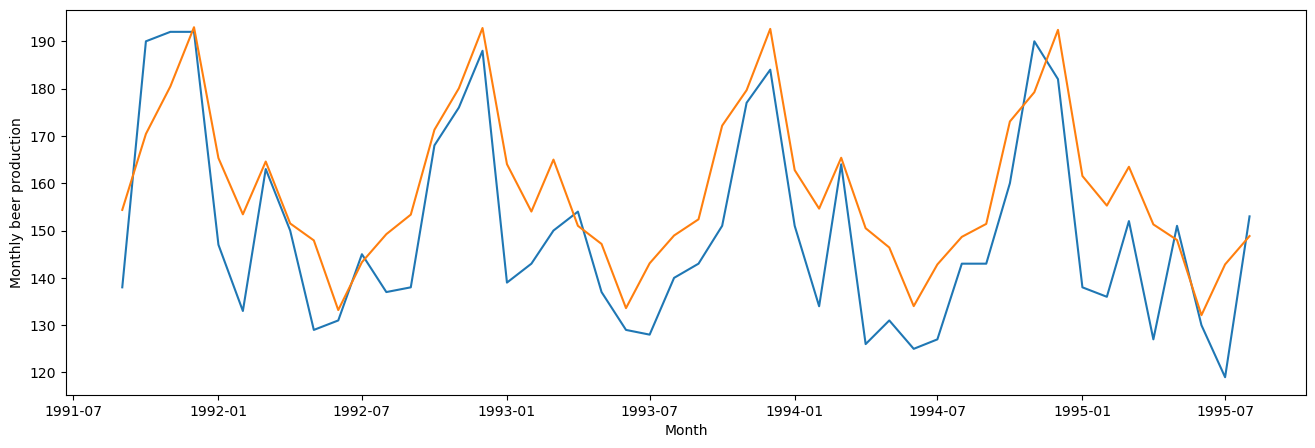

In [76]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["Monthly beer production"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [77]:
#The root mean square error (RMSE) between the Prophet model predictions and the actual values of monthly beer production.
prophet_rmse_error = rmse(test_data['Monthly beer production'], test_data["Prophet_Predictions"])

#The mean square error (MSE) by squaring the RMSE.
prophet_mse_error = prophet_rmse_error**2

#The average value of monthly beer production.
mean_value = df['Monthly beer production'].mean()

#print the MSE, RMSE and mean values.
print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 184.5407022977258
RMSE Error: 13.584575896866482
Mean: 136.3953781512605


In [78]:
#Lists the RMSE for the LSTM and Prophet models.
rmse_errors = [ lstm_rmse_error, prophet_rmse_error]

#Lists the MSE for the LSTM and Prophet models.
mse_errors = [lstm_mse_error, prophet_mse_error]

#Create a new DataFrame containing the RMSE and MSE errors for the LSTM and Prophet models.
errors = pd.DataFrame({"Models" : ["LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


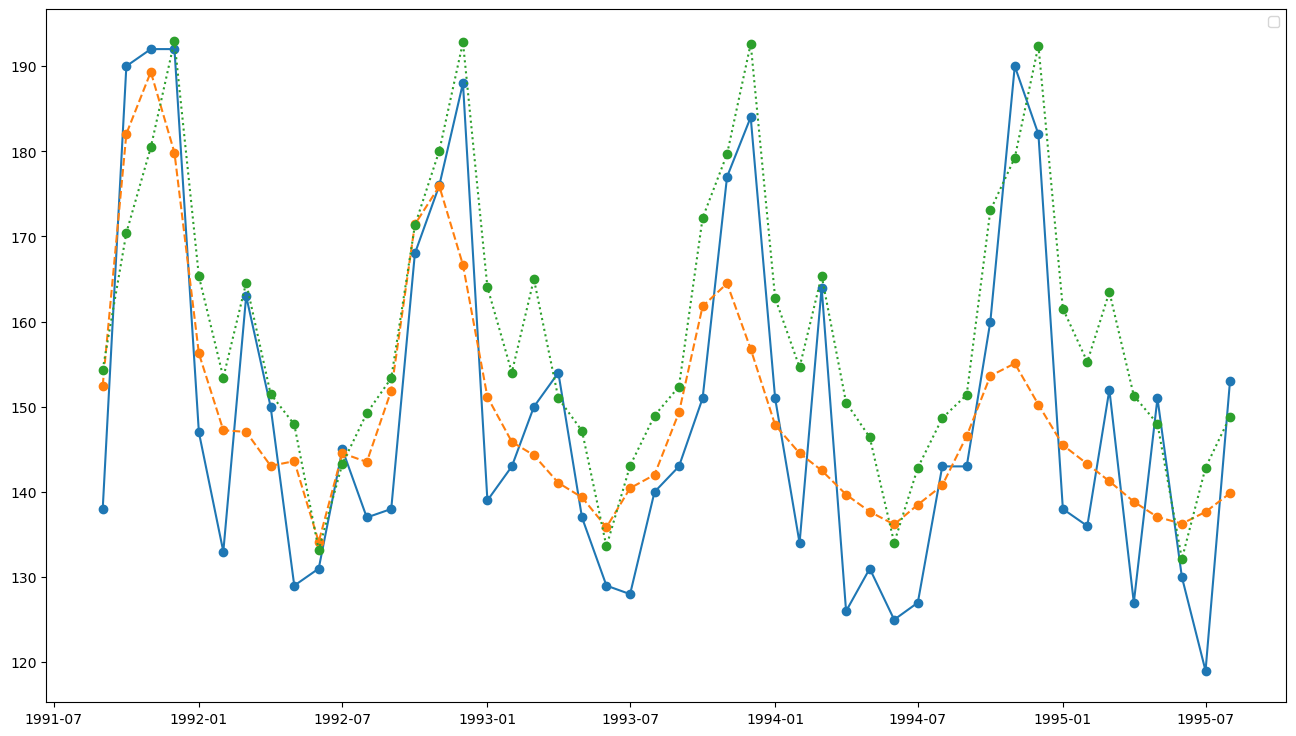

In [79]:
#graph of the LSTM and Prophet model predictions along with monthly beer production.
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["Monthly beer production"], linestyle="-")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

In [80]:
#the average value of monthly beer production in the test data set.
print(f"Mean: {test_data['Monthly beer production'].mean()}")

#Data frame errors
errors

Mean: 149.45833333333334


,Models,RMSE Errors,MSE Errors
0,LSTM,12.945426,167.584044
1,Prophet,13.584576,184.540702


In [81]:
##Data frame test_data
test_data

,Monthly beer production,LSTM_Predictions,Prophet_Predictions
Month,,,
1991-09-01,138.0,152.493333,154.368488
1991-10-01,190.0,182.048974,170.425487
1991-11-01,192.0,189.317297,180.458872
1991-12-01,192.0,179.839189,192.976887
1992-01-01,147.0,156.256435,165.318185
1992-02-01,133.0,147.242829,153.431556
1992-03-01,163.0,147.049085,164.587897
1992-04-01,150.0,143.064078,151.499037
1992-05-01,129.0,143.614067,147.923060
